# Idea

## Результат (ожидаемый)

* обучение происходит на своем родном канале на симулированных данных
* учитываются различия симуляции и данных (см. ниже алгоритм)
* оценка качества (как и калибровка) будут несмещенными
* качество лучше, чем baseline

## Алгоритм

* используем инклюзивный подход
* учим при помощи классификатора перевзвешивание различия данных (удаляем треки из симуляции, которые не появляются в данных и удаляем из данных треки, которые не умеем симулировать):

    - классификатор предсказывает $p(MC)$ и $p(RD)$
    
    - для симуляции при $p(MC)>0.5$
    
        $$w_{MC}=\frac{p(RD)}{p(MC)},$$
       иначе
        $$w_{MC}=1$$
    - для данных при $p(MC)<0.5$
        $$w_{RD}=\frac{p(MC)}{p(RD)},$$
       иначе
        $$w_{RD}=1$$
    - нормируем веса в событии
    - в формуле комбинирования возводим в степень $w * sign$

In [260]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


In [261]:
import sys
sys.path.insert(0, "../")

## Import

In [262]:
import pandas
import numpy
from folding_group import FoldingGroupClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_curve, roc_auc_score
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

## Reading initial data

In [4]:
import root_numpy
MC = pandas.DataFrame(root_numpy.root2array('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root', stop=5000000))
data = pandas.DataFrame(root_numpy.root2array('../datasets/data/csv/WG/Bu_JPsiK/2012/Tracks.root', stop=5000000))

In [5]:
data.head()

,run,event,Bmass,time,i,mult,partP,partPt,ptB,IPs,...,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,OS_SS,xFlag,K_MCID,BOosc
0,132623,227572384.0,5.280417,2.739783,0,16,2.975773,0.125786,6.62858,0.346570,...,1.0,1.714190,1.12428,0,0,0,0.0,-0.000563,0,-1878611067
1,132623,227572384.0,5.280417,2.739783,1,16,2.113523,0.626089,6.62858,1.647396,...,1.0,0.118375,1.12428,0,0,0,0.0,1.000000,0,-1878611067
2,132623,227572384.0,5.280417,2.739783,2,16,3.391397,0.237943,6.62858,2.565533,...,-1.0,2.131909,1.12428,0,0,0,0.0,1.000000,0,-1878611067
3,132623,227572384.0,5.280417,2.739783,3,16,12.321827,0.512020,6.62858,2.054170,...,-1.0,1.768889,1.12428,0,0,0,0.0,0.000000,0,-1878611067
4,132623,227572384.0,5.280417,2.739783,4,16,47.236053,1.710158,6.62858,0.995251,...,1.0,1.990477,1.12428,0,0,0,0.0,-0.000000,0,-1878611067


In [6]:
MC.head()

,run,event,Bmass,time,i,mult,partP,partPt,ptB,IPs,...,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,MCID,OS_SS,xFlag,K_MCID,BOosc
0,2517778,1110804.0,5.272273,0.41804,0,12,10.10731,1.275867,3.046546,45.846935,...,0.318931,0.0,0,0,1,-321.0,0.0,0.0,-1,0
1,2517778,1110804.0,5.272273,0.41804,1,12,12.52366,0.513155,3.046546,4.899704,...,1.151553,0.0,0,0,0,211.0,0.0,0.0,-1,0
2,2517778,1110804.0,5.272273,0.41804,2,12,4.71373,0.597545,3.046546,3.352034,...,0.544899,0.0,0,0,0,-211.0,-1.0,-1.0,-1,0
3,2517778,1110804.0,5.272273,0.41804,3,12,4.68713,0.243792,3.046546,102.329247,...,0.395680,0.0,0,0,0,-211.0,0.0,0.0,-1,0
4,2517778,1110804.0,5.272273,0.41804,4,12,3.21920,0.612911,3.046546,1.016178,...,0.269237,0.0,0,0,0,211.0,-1.0,-1.0,-1,0


### Data preprocessing: 

Add necessary features:
- #### define `label` = `signB` * `signTrack`

    * if > 0 (same sign) - label **1**
    * if < 0 (different sign) - label **0**

- #### diff pt, min/max PID

Apply selections:

- **remove ghost tracks**
- **loose selection on PID**

In [7]:
from utils import data_tracks_preprocessing
data = data_tracks_preprocessing(data, N_sig_sw=True)
MC = data_tracks_preprocessing(MC)

Initial statistics: {'parts': 5000000, 'Events': 178954}
after  (ghostProb < 0.4)  selection, statistics: {'parts': 4685305, 'Events': 178947}
after   ( (PIDNNk > 0.0) | (PIDNNm > 0.0) | (PIDNNe > 0.0) | (PIDNNpi > 0.0) | (PIDNNp > 0.0))   selection, statistics: {'parts': 4677546, 'Events': 178947}


/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Initial statistics: {'parts': 4997009, 'Events': 218087}
after  (ghostProb < 0.4)  selection, statistics: {'parts': 4873085, 'Events': 218086}
after   ( (PIDNNk > 0.0) | (PIDNNm > 0.0) | (PIDNNe > 0.0) | (PIDNNpi > 0.0) | (PIDNNp > 0.0))   selection, statistics: {'parts': 4872280, 'Events': 218086}


In [8]:
', '.join(data.columns)

'run, event, Bmass, time, i, mult, partP, partPt, ptB, IPs, IP, IPerr, partlcs, EOverP, ghostProb, IPPU, nnkrec, PIDNNk, PIDNNpi, PIDNNp, PIDNNm, PIDNNe, diff_eta, diff_phi, phi, eta, proj, ID, veloch, signB, signTrack, Dist_phi, N_sig_sw, mu_cut, e_cut, K_cut, OS_SS, xFlag, K_MCID, BOosc, group_column, event_id, diff_pt, cos_diff_phi, max_PID_mu_k, sum_PID_mu_k, max_PID_mu_e, sum_PID_mu_e, max_PID_k_e, sum_PID_k_e, label'

In [9]:
print sum(data.signB == 1), sum(data.signB == -1)
print sum(MC.signB == 1), sum(MC.signB == -1)

2370741 2306805
2462725 2409555


#### Define mask for non-B events

In [10]:
mask_sw_positive = (data.N_sig_sw.values > 1) * 1

In [11]:
data.head()

,run,event,Bmass,time,i,mult,partP,partPt,ptB,IPs,...,event_id,diff_pt,cos_diff_phi,max_PID_mu_k,sum_PID_mu_k,max_PID_mu_e,sum_PID_mu_e,max_PID_k_e,sum_PID_k_e,label
0,132623,227572384.0,5.280417,2.739783,0,16,2.975773,0.125786,6.62858,0.346570,...,132623_227572384,3.636832,-0.878069,0.003009,-999.997009,8.195478e-01,-999.180481,0.819548,0.822557,False
1,132623,227572384.0,5.280417,2.739783,1,16,2.113523,0.626089,6.62858,1.647396,...,132623_227572384,3.136530,0.769140,0.073602,-999.926392,8.000000e-08,-1000.000000,0.073602,0.073602,False
2,132623,227572384.0,5.280417,2.739783,2,16,3.391397,0.237943,6.62858,2.565533,...,132623_227572384,3.524675,-0.906972,0.007654,0.012911,7.654380e-03,0.007655,0.005256,0.005257,True
3,132623,227572384.0,5.280417,2.739783,3,16,12.321827,0.512020,6.62858,2.054170,...,132623_227572384,3.250599,-0.902918,0.000420,-999.999573,9.117000e-05,-999.999939,0.000420,0.000511,True
4,132623,227572384.0,5.280417,2.739783,4,16,47.236053,1.710158,6.62858,0.995251,...,132623_227572384,2.052460,-0.975305,0.968372,-999.031616,4.750000e-06,-1000.000000,0.968372,0.968377,False


In [12]:
data['group_column'] = numpy.unique(data.event_id, return_inverse=True)[1]
MC['group_column'] = numpy.unique(MC.event_id, return_inverse=True)[1]
data.index = numpy.arange(len(data))
MC.index = numpy.arange(len(MC))

## Define features

In [13]:
# features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
#             'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
#             'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
#             'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

In [14]:
features = ['cos_diff_phi', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

# Test that B-events similar in MC and data

In [53]:
b_ids_data = numpy.unique(data.group_column.values, return_index=True)[1]
b_ids_MC = numpy.unique(MC.group_column.values, return_index=True)[1]

In [54]:
Bdata = data.iloc[b_ids_data].copy()
BMC = MC.iloc[b_ids_MC].copy()

Bdata['Beta'] = Bdata.diff_eta + Bdata.eta
BMC['Beta'] = BMC.diff_eta + BMC.eta

Bdata['Bphi'] = Bdata.diff_phi + Bdata.phi
BMC['Bphi'] = BMC.diff_phi + BMC.phi

In [56]:
Bfeatures = ['Beta', 'Bphi', 'ptB']

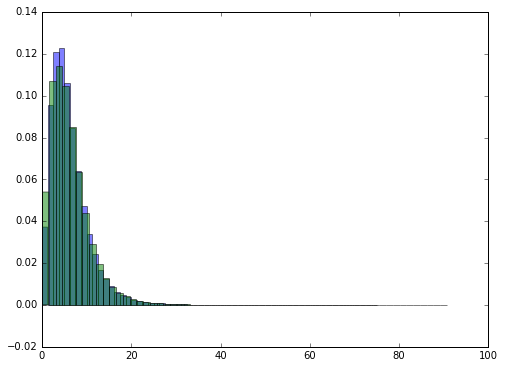

In [57]:
hist(Bdata['ptB'].values, normed=True, alpha=0.5, bins=60, 
     weights=Bdata['N_sig_sw'].values)
hist(BMC['ptB'].values, normed=True, alpha=0.5, bins=60);

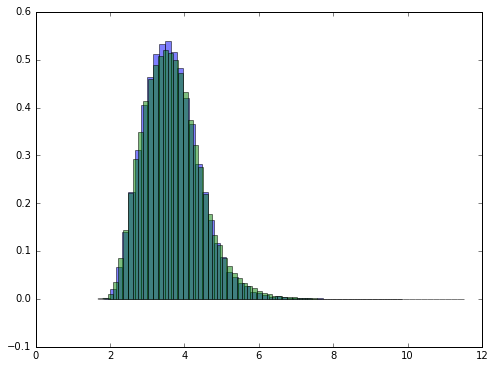

In [58]:
hist(Bdata['Beta'].values, normed=True, alpha=0.5, bins=60, 
     weights=Bdata['N_sig_sw'].values)
hist(BMC['Beta'].values, normed=True, alpha=0.5, bins=60);

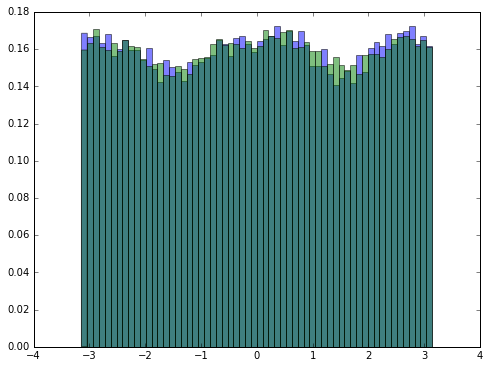

In [59]:
hist(Bdata['Bphi'].values, normed=True, alpha=0.5, bins=60, 
     weights=Bdata['N_sig_sw'].values)
hist(BMC['Bphi'].values, normed=True, alpha=0.5, bins=60);

In [60]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1000,
                                  n_threads=16)

In [61]:
data_vs_MC_B = pandas.concat([Bdata, BMC])
label_data_vs_MC_B = [0] * len(Bdata) + [1] * len(BMC)
weights_data_vs_MC_B = numpy.concatenate([Bdata.N_sig_sw.values * (Bdata.N_sig_sw.values > 1) * 1, 
                                          numpy.ones(len(BMC))])
weights_data_vs_MC_B_all = numpy.concatenate([Bdata.N_sig_sw.values, numpy.ones(len(BMC))])

In [62]:
tt_B = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                              train_features=Bfeatures, group_feature='group_column')
%time tt_B.fit(data_vs_MC_B, label_data_vs_MC_B, sample_weight=weights_data_vs_MC_B)
pass

CPU times: user 54.7 s, sys: 330 ms, total: 55.1 s
Wall time: 5.65 s


In [63]:
roc_auc_score(label_data_vs_MC_B, tt_B.predict_proba(data_vs_MC_B)[:, 1], sample_weight=weights_data_vs_MC_B)

KFold prediction using folds column


0.53348108961515373

In [64]:
roc_auc_score(label_data_vs_MC_B, tt_B.predict_proba(data_vs_MC_B)[:, 1], sample_weight=weights_data_vs_MC_B_all)

KFold prediction using folds column


0.51020867906251355

In [65]:
from hep_ml.reweight import GBReweighter, FoldingReweighter

In [66]:
reweighterB = FoldingReweighter(GBReweighter(), random_state=3444)
reweighterB.fit(BMC[Bfeatures], Bdata[Bfeatures], target_weight=Bdata.N_sig_sw)

FoldingReweighter(base_reweighter=GBReweighter(gb_args=None, learning_rate=0.2, loss_regularization=5.0,
       max_depth=3, min_samples_leaf=200, n_estimators=40),
         n_folds=2, random_state=3444, verbose=True)

In [67]:
BMC_weights = reweighterB.predict_weights(BMC[Bfeatures])

KFold prediction using folds column


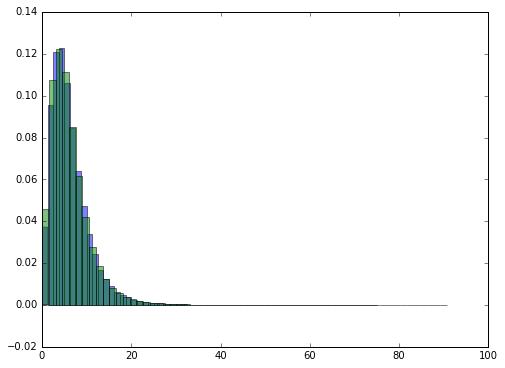

In [68]:
hist(Bdata['ptB'].values, normed=True, alpha=0.5, bins=60, 
     weights=Bdata['N_sig_sw'].values)
hist(BMC['ptB'].values, normed=True, alpha=0.5, bins=60, weights=BMC_weights);

In [69]:
weights_data_vs_MC_B_w = numpy.concatenate([Bdata.N_sig_sw.values * (Bdata.N_sig_sw.values > 1) * 1, 
                                            BMC_weights])
weights_data_vs_MC_B_all_w = numpy.concatenate([Bdata.N_sig_sw.values, BMC_weights])

In [70]:
tt_B = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                              train_features=Bfeatures, group_feature='group_column')
%time tt_B.fit(data_vs_MC_B, label_data_vs_MC_B, sample_weight=weights_data_vs_MC_B_w)

roc_auc_score(label_data_vs_MC_B, tt_B.predict_proba(data_vs_MC_B)[:, 1], sample_weight=weights_data_vs_MC_B_all_w)

CPU times: user 51.6 s, sys: 201 ms, total: 51.8 s
Wall time: 5.42 s
KFold prediction using folds column


0.50118693500779943

In [71]:
MC['N_sig_sw'] = BMC_weights[numpy.unique(MC.group_column.values, return_inverse=True)[1]]

## Test that number of tracks is independent on Track description

In [73]:
def compute_target_number_of_tracks(X):
    ids = numpy.unique(X.group_column, return_inverse=True)[1]
    number_of_tracks = numpy.bincount(X.group_column)
    target = number_of_tracks[ids]
    return target

In [74]:
from decisiontrain import DecisionTrainRegressor
from rep.estimators import SklearnRegressor
from rep.metaml import FoldingRegressor

In [75]:
tt_base_reg = DecisionTrainRegressor(learning_rate=0.02, n_estimators=1000,
                                     n_threads=16)

In [76]:
%%time
tt_data_NT = FoldingRegressor(SklearnRegressor(tt_base_reg), n_folds=2, random_state=321, 
                              features=features)
tt_data_NT.fit(data, compute_target_number_of_tracks(data), sample_weight=data.N_sig_sw.values * mask_sw_positive)

CPU times: user 7min 33s, sys: 2.91 s, total: 7min 35s
Wall time: 1min 21s


In [77]:
from sklearn.metrics import mean_squared_error
mean_squared_error(compute_target_number_of_tracks(data), tt_data_NT.predict(data),
                   sample_weight=data.N_sig_sw.values) ** 0.5

KFold prediction using folds column


11.052412646370819

In [83]:
mean_squared_error(compute_target_number_of_tracks(data), 
                   [numpy.mean(compute_target_number_of_tracks(data))] * len(data), 
                   sample_weight=data.N_sig_sw.values) ** 0.5

11.874056134687182

In [92]:
%%time
tt_MC_NT = FoldingRegressor(SklearnRegressor(tt_base_reg), n_folds=2, random_state=321, 
                            features=features)
tt_MC_NT.fit(MC, compute_target_number_of_tracks(MC), sample_weight=MC.N_sig_sw.values)

CPU times: user 8min 13s, sys: 3.68 s, total: 8min 17s
Wall time: 1min 27s


In [93]:
mean_squared_error(compute_target_number_of_tracks(MC),
                   tt_MC_NT.predict(MC), sample_weight=MC.N_sig_sw.values) ** 0.5

KFold prediction using folds column


10.703249676132344

In [94]:
mean_squared_error(compute_target_number_of_tracks(MC),
                   [numpy.mean(compute_target_number_of_tracks(MC))] * len(MC),
                   sample_weight=MC.N_sig_sw.values) ** 0.5

11.280995798543337

In [95]:
tt_MC_NT.get_feature_importances().sort_values(by='effect')[-5:]

,effect
IPerr,0.507937
EOverP,0.686508
PIDNNe,0.777778
IPPU,0.888889
ghostProb,1.000000


## Define base estimator and B weights, labels

In [96]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1000,
                                  n_threads=16)

In [97]:
B_signs = data['signB'].groupby(data['group_column']).aggregate(numpy.mean)
B_weights = data['N_sig_sw'].groupby(data['group_column']).aggregate(numpy.mean)

In [98]:
B_signs_MC = MC['signB'].groupby(MC['group_column']).aggregate(numpy.mean)
B_weights_MC = MC['N_sig_sw'].groupby(MC['group_column']).aggregate(numpy.mean)

### B probability computation

In [99]:
from scipy.special import logit, expit
def compute_Bprobs(X, track_proba, weights=None, normed_weights=False):
    if weights is None:
        weights = numpy.ones(len(X))
    _, data_ids = numpy.unique(X['group_column'], return_inverse=True)
    
    track_proba[~numpy.isfinite(track_proba)] = 0.5
    track_proba[numpy.isnan(track_proba)] = 0.5
    
    if normed_weights:
        weights_per_events = numpy.bincount(data_ids, weights=weights)
        weights /= weights_per_events[data_ids]
    predictions = numpy.bincount(data_ids, weights=logit(track_proba) * X['signTrack'] * weights)
    return expit(predictions)

## Inclusive tagging: training on data

In [100]:
tt_data = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                                 train_features=features, group_feature='group_column')
%time tt_data.fit(data, data.label, sample_weight=data.N_sig_sw.values * mask_sw_positive)
pass

CPU times: user 8min 41s, sys: 3.49 s, total: 8min 44s
Wall time: 1min 24s


In [101]:
pandas.DataFrame({'dataset': ['MC', 'data'], 
                  'quality': [roc_auc_score(
                B_signs_MC, compute_Bprobs(MC, tt_data.predict_proba(MC)[:, 1]), sample_weight=B_weights_MC),
                             roc_auc_score(
                B_signs, compute_Bprobs(data, tt_data.predict_proba(data)[:, 1]), sample_weight=B_weights)]})

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column


,dataset,quality
0,MC,0.649913
1,data,0.640670


## Inclusive tagging: training on MC

In [102]:
tt_MC = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                               train_features=features, group_feature='group_column')
%time tt_MC.fit(MC, MC.label)
pass

CPU times: user 8min 17s, sys: 3.28 s, total: 8min 21s
Wall time: 1min 8s


In [103]:
pandas.DataFrame({'dataset': ['MC', 'data'], 
                  'quality': [roc_auc_score(
                B_signs_MC, compute_Bprobs(MC, tt_MC.predict_proba(MC)[:, 1]), sample_weight=B_weights_MC),
                             roc_auc_score(
                B_signs, compute_Bprobs(data, tt_MC.predict_proba(data)[:, 1]), sample_weight=B_weights)]})

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


,dataset,quality
0,MC,0.658694
1,data,0.641292


## New method

### Reweighting with classifier

combine data and MC together to train a classifier

In [236]:
combined_data_MC = pandas.concat([data, MC])
combined_label = numpy.array([0] * len(data) + [1] * len(MC))

combined_weights_data = data.N_sig_sw.values #/ numpy.bincount(data.group_column)[data.group_column.values]
combined_weights_data_passed = combined_weights_data * mask_sw_positive
combined_weights_MC = MC.N_sig_sw.values# / numpy.bincount(MC.group_column)[MC.group_column.values]
combined_weights = numpy.concatenate([combined_weights_data_passed, 
                                      1. * combined_weights_MC / sum(combined_weights_MC) * sum(combined_weights_data_passed)])
combined_weights_all = numpy.concatenate([combined_weights_data, 
                                          1. * combined_weights_MC / sum(combined_weights_MC) * sum(combined_weights_data)])

#### train classifier to distinguish data and MC

In [276]:
%%time 
tt_base_large = DecisionTrainClassifier(learning_rate=0.3, n_estimators=1000,
                                        n_threads=20)
tt_data_vs_MC = FoldingGroupClassifier(SklearnClassifier(tt_base_large), n_folds=2, random_state=321, 
                                       train_features=features + ['label'], group_feature='group_column')
tt_data_vs_MC.fit(combined_data_MC, combined_label, sample_weight=combined_weights)

CPU times: user 19min 28s, sys: 15.9 s, total: 19min 44s
Wall time: 3min 30s


In [277]:
a = []
for n, p in enumerate(tt_data_vs_MC.staged_predict_proba(combined_data_MC)):
    a.append(roc_auc_score(combined_label, p[:, 1], sample_weight=combined_weights))

KFold prediction using folds column


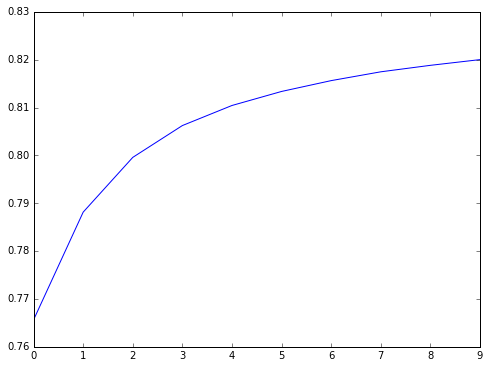

In [278]:
plot(a)

quality

In [279]:
combined_p = tt_data_vs_MC.predict_proba(combined_data_MC)[:, 1]
roc_auc_score(combined_label, combined_p, sample_weight=combined_weights)

KFold prediction using folds column


0.82004320823796661

In [280]:
roc_auc_score(combined_label, combined_p, sample_weight=combined_weights_all)

0.81490294553177545

calibrate probabilities (due to reweighting rule where probabilities are used)

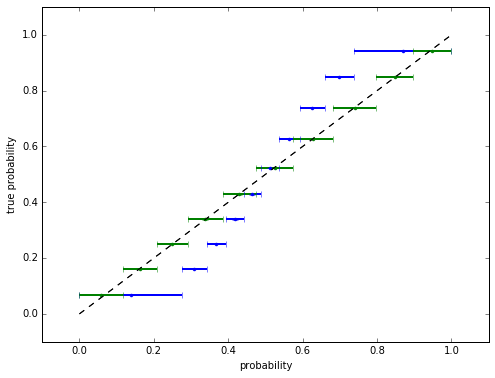

In [281]:
from utils import calibrate_probs, plot_calibration
combined_p_calib = calibrate_probs(combined_label, combined_weights, combined_p)[0]

plot_calibration(combined_p, combined_label, weight=combined_weights)
plot_calibration(combined_p_calib, combined_label, weight=combined_weights)

#### compute MC and data track weights

In [282]:
# reweight data predicted as data to MC
used_probs = combined_p_calib
data_probs_to_be_MC = used_probs[combined_label == 0]
MC_probs_to_be_MC = used_probs[combined_label == 1]

track_weights_data = numpy.ones(len(data))
# take data with probability to be data
mask_data = data_probs_to_be_MC < 0.5
track_weights_data[mask_data] = (data_probs_to_be_MC[mask_data]) / (1 - data_probs_to_be_MC[mask_data])

# reweight MC predicted as MC to data
track_weights_MC = numpy.ones(len(MC))
mask_MC = MC_probs_to_be_MC > 0.5
track_weights_MC[mask_MC] = (1 - MC_probs_to_be_MC[mask_MC]) / (MC_probs_to_be_MC[mask_MC])

# simple approach, reweight only MC
track_weights_only_MC = (1 - MC_probs_to_be_MC) / MC_probs_to_be_MC

In [283]:
# data_ids = numpy.unique(data['group_column'], return_inverse=True)[1]
# MC_ids = numpy.unique(MC['group_column'], return_inverse=True)[1]

# # event_weight_data = (numpy.bincount(data_ids, weights=data.N_sig_sw) / numpy.bincount(data_ids))[data_ids]
# # event_weight_MC = (numpy.bincount(MC_ids, weights=MC.N_sig_sw) / numpy.bincount(MC_ids))[MC_ids]

# # normalize weights for tracks in a way that sum w_track = 1 per event
# track_weights_data /= numpy.bincount(data_ids, weights=track_weights_data)[data_ids]
# track_weights_MC /= numpy.bincount(MC_ids, weights=track_weights_MC)[MC_ids]

#### reweighting plotting

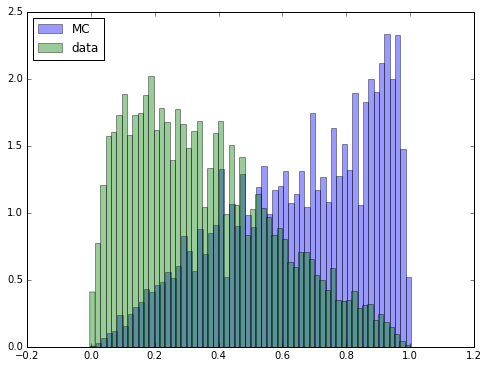

In [284]:
hist(combined_p_calib[combined_label == 1], label='MC', normed=True, alpha=0.4, bins=60,
     weights=combined_weights_MC)
hist(combined_p_calib[combined_label == 0], label='data', normed=True, alpha=0.4, bins=60, 
     weights=combined_weights_data);
legend(loc='best')

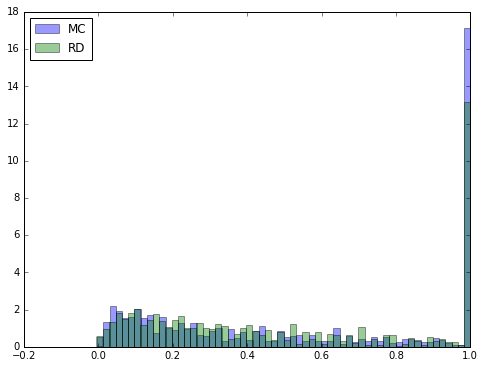

In [285]:
hist(track_weights_MC, normed=True, alpha=0.4, bins=60, label='MC')
hist(track_weights_data, normed=True, alpha=0.4, bins=60, label='RD');
legend(loc='best')

In [286]:
numpy.mean(track_weights_data), numpy.mean(track_weights_MC)

(0.48831590598212582, 0.52141568467765975)

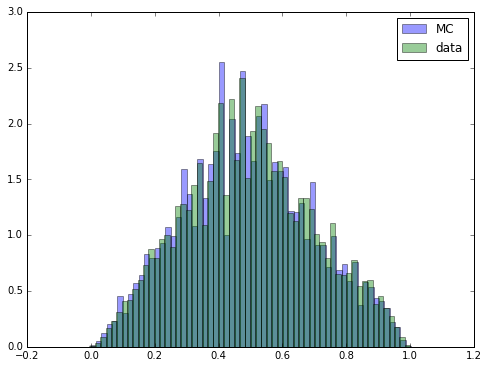

In [287]:
hist(combined_p_calib[combined_label == 1], label='MC', normed=True, alpha=0.4, bins=60, 
     weights=track_weights_MC * MC.N_sig_sw.values)
hist(combined_p_calib[combined_label == 0], label='data', normed=True, alpha=0.4, bins=60, 
     weights=track_weights_data * data.N_sig_sw.values);
legend(loc='best')

In [288]:
roc_auc_score(combined_label, combined_p_calib,
              sample_weight=numpy.concatenate([track_weights_data * data.N_sig_sw.values,
                                               track_weights_MC * MC.N_sig_sw.values]))

0.49389963524852626

### Check reweighting rule

train classifier to distinguish data vs MC with provided weights

In [289]:
%%time 
tt_check = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=433, 
                                  train_features=features + ['label'], group_feature='group_column')
tt_check.fit(combined_data_MC, combined_label, 
             sample_weight=numpy.concatenate([track_weights_data * data.N_sig_sw.values * mask_sw_positive, 
                                              track_weights_MC * MC.N_sig_sw.values]))

CPU times: user 16min 12s, sys: 13.2 s, total: 16min 25s
Wall time: 3min 30s


In [290]:
roc_auc_score(combined_label, tt_check.predict_proba(combined_data_MC)[:, 1],
              sample_weight=numpy.concatenate([track_weights_data * data.N_sig_sw.values * mask_sw_positive, 
                                              track_weights_MC * MC.N_sig_sw.values]))
# * sum(track_weights_data * mask_sw_positive) / sum(track_weights_MC)

KFold prediction using folds column


0.53335248890854536

In [291]:
roc_auc_score(combined_label, tt_check.predict_proba(combined_data_MC)[:, 1],
              sample_weight=numpy.concatenate([track_weights_data * data.N_sig_sw.values, 
                                              track_weights_MC * MC.N_sig_sw.values]))
# * sum(track_weights_data) / sum(track_weights_MC)

KFold prediction using folds column


0.53546922584908141

### Classifier trained on MC

In [292]:
tt_reweighted_MC = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                                          train_features=features, group_feature='group_column')
%time tt_reweighted_MC.fit(MC, MC.label, sample_weight=track_weights_MC * MC.N_sig_sw.values)
pass

CPU times: user 8min 24s, sys: 3.56 s, total: 8min 27s
Wall time: 1min 26s


In [293]:
pandas.DataFrame({'dataset': ['MC', 'data'], 
                  'quality': [roc_auc_score(
                B_signs_MC, 
                compute_Bprobs(MC, tt_reweighted_MC.predict_proba(MC)[:, 1], 
                               weights=track_weights_MC, normed_weights=False),
                sample_weight=B_weights_MC),
                             roc_auc_score(
                B_signs, 
                compute_Bprobs(data, tt_reweighted_MC.predict_proba(data)[:, 1], 
                               weights=track_weights_data, normed_weights=False),
                sample_weight=B_weights)]})

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


,dataset,quality
0,MC,0.613022
1,data,0.611099


In [254]:
pandas.DataFrame({'dataset': ['MC', 'data'], 
                  'quality': [roc_auc_score(
                B_signs_MC, 
                compute_Bprobs(MC, tt_reweighted_MC.predict_proba(MC)[:, 1], 
                               weights=track_weights_MC, normed_weights=False),
                sample_weight=B_weights_MC),
                             roc_auc_score(
                B_signs, 
                compute_Bprobs(data, tt_reweighted_MC.predict_proba(data)[:, 1], 
                               weights=track_weights_data, normed_weights=False),
                sample_weight=B_weights)]})

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


,dataset,quality
0,MC,0.607195
1,data,0.611895


### Classifier trained on data

In [294]:
%%time 
tt_reweighted_data = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                                            train_features=features, group_feature='group_column')
tt_reweighted_data.fit(data, data.label, 
                       sample_weight=track_weights_data * data.N_sig_sw.values * mask_sw_positive)
pass

CPU times: user 8min, sys: 2.96 s, total: 8min 2s
Wall time: 1min 20s


In [295]:
pandas.DataFrame({'dataset': ['MC', 'data'], 
                  'quality': [roc_auc_score(
                B_signs_MC, 
                compute_Bprobs(MC, tt_reweighted_data.predict_proba(MC)[:, 1], 
                               weights=track_weights_MC, normed_weights=False),
                sample_weight=B_weights_MC),
                             roc_auc_score(
                B_signs, 
                compute_Bprobs(data, tt_reweighted_data.predict_proba(data)[:, 1], 
                               weights=track_weights_data, normed_weights=False),
                sample_weight=B_weights)]})

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column


,dataset,quality
0,MC,0.606442
1,data,0.609192


In [256]:
pandas.DataFrame({'dataset': ['MC', 'data'], 
                  'quality': [roc_auc_score(
                B_signs_MC, 
                compute_Bprobs(MC, tt_reweighted_data.predict_proba(MC)[:, 1], 
                               weights=track_weights_MC, normed_weights=False),
                sample_weight=B_weights_MC),
                             roc_auc_score(
                B_signs, 
                compute_Bprobs(data, tt_reweighted_data.predict_proba(data)[:, 1], 
                               weights=track_weights_data, normed_weights=False),
                sample_weight=B_weights)]})

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column


,dataset,quality
0,MC,0.604353
1,data,0.606769


------------------------

In [58]:
numpy.mean(mc_sum_weights_per_event), numpy.mean(data_sum_weights_per_event)

(7.3125750470561259, 18.005772961549471)

In [74]:
_, data_ids = numpy.unique(data['group_column'], return_inverse=True)
mc_sum_weights_per_event = numpy.bincount(MC.group_column.values, weights=track_weights_MC)
data_sum_weights_per_event = numpy.bincount(data_ids, weights=track_weights_data)

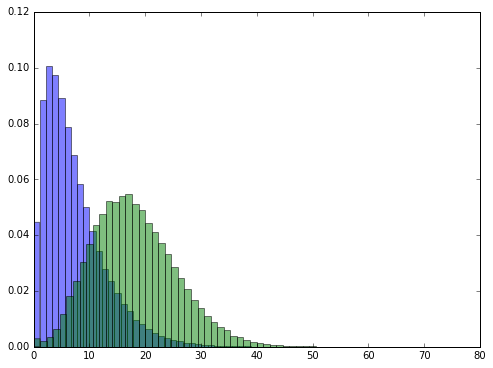

In [77]:
hist(mc_sum_weights_per_event, bins=60, normed=True, alpha=0.5)
hist(data_sum_weights_per_event, bins=60, normed=True, alpha=0.5, weights=B_weights);

In [268]:
hist(mc_sum_weights_per_event, bins=60, normed=True, alpha=0.5)
hist(data_sum_weights_per_event, bins=60, normed=True, alpha=0.5, weights=B_weights);

NameError: name 'mc_sum_weights_per_event' is not defined

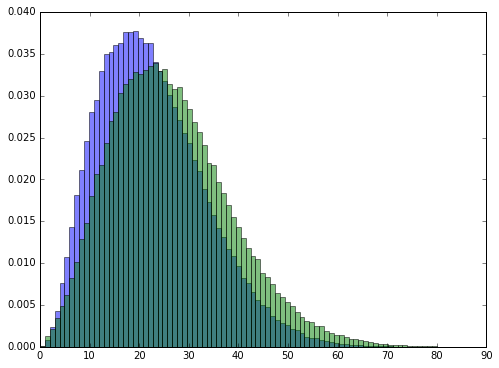

In [55]:
hist(numpy.bincount(MC.group_column), bins=81, normed=True, alpha=0.5, range=(0, 80))
hist(numpy.bincount(data.group_column), bins=81, normed=True, alpha=0.5, range=(0, 80));

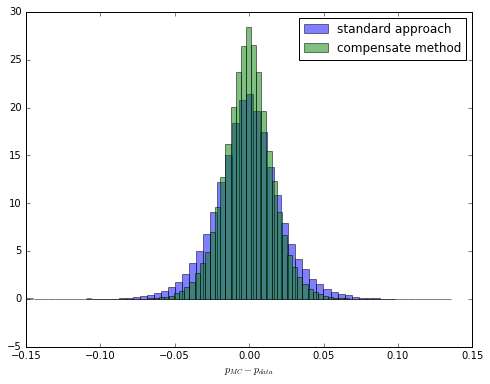

In [261]:
hist(expit(p_tt_mc) - expit(p_data), bins=60, weights=B_weights, normed=True, label='standard approach',
     alpha=0.5);
hist(expit(p_data_w_MC) - expit(p_data_w), bins=60, weights=B_weights, normed=True, label='compensate method',
     alpha=0.5);
legend()
xlabel('$p_{MC}-p_{data}$')

## Calibration

In [200]:
from utils import compute_mistag

(0.2, 0.5)

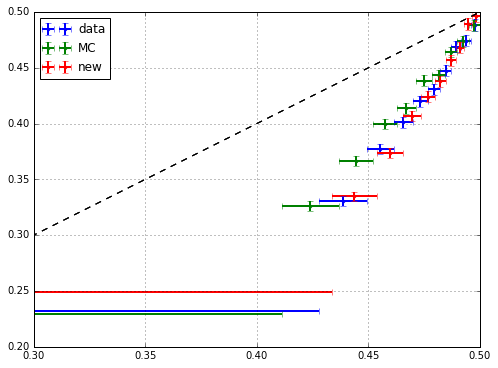

In [87]:
bins_perc = [10, 20, 30, 40, 50, 60, 70, 80, 90]
compute_mistag(expit(p_data), B_signs, B_weights, chosen=numpy.ones(len(B_signs), dtype=bool),
               bins=bins_perc,
               uniform=False, label='data')

compute_mistag(expit(p_tt_mc), B_signs, B_weights, chosen=numpy.ones(len(B_signs), dtype=bool),
               bins=bins_perc,
               uniform=False, label='MC')

compute_mistag(expit(p_data_w), B_signs, B_weights, chosen=numpy.ones(len(B_signs), dtype=bool),
               bins=bins_perc,
               uniform=False, label='new')

legend(loc='best')
xlim(0.3, 0.5)
ylim(0.2, 0.5)

AssertionError: 

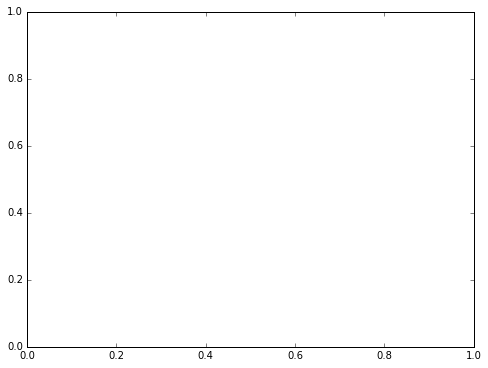

In [82]:
bins_edg = numpy.linspace(0.3, 0.9, 10)
compute_mistag(expit(p_data), B_signs, B_weights, chosen=numpy.ones(len(B_signs), dtype=bool),
               bins=bins_edg,
               uniform=True, label='data')

compute_mistag(expit(p_tt_mc), B_signs, B_weights, chosen=numpy.ones(len(B_signs), dtype=bool),
               bins=bins_edg,
               uniform=True, label='MC')

compute_mistag(expit(p_data_w), B_signs, B_weights, chosen=numpy.ones(len(B_signs), dtype=bool),
               bins=bins_edg,
               uniform=True, label='new')

legend(loc='best')